# BAGIAN 1: PERSIAPAN LINGKUNGAN

1: Judul dan Deskripsi

***Proyek Sistem Fuzzy: Klasifikasi Sampah (Dataset "Garbage Classification")***

Notebook ini menggunakan dataset gambar dari Kaggle. Langkah-langkahnya meliputi:
1.  Mengunduh dataset.
2.  **Feature Engineering**: Membuat tabel fitur dari struktur folder gambar.
3.  **Induksi Aturan**: Mengekstrak aturan IF-THEN menggunakan pendekatan Rough Set.
4.  **Implementasi Fuzzy**: Membangun dan menguji sistem inferensi fuzzy.

2: Instalasi Library

In [ ]:
# Menginstal library yang dibutuhkan
print("Menginstal library...")
!pip install -q scikit-fuzzy kaggle kagglehub
print("Instalasi selesai.")

Menginstal library...
Instalasi selesai.


3: Konfigurasi Kaggle API

**PENTING: Konfigurasi API Kaggle**

Untuk melanjutkan, Anda perlu API token dari Kaggle.
1.  Buka akun Kaggle Anda, masuk ke **Account** -> **API**.
2.  Klik **"Create New API Token"**. Ini akan mengunduh file `kaggle.json`.
3.  Jalankan sel kode di bawah ini, lalu unggah file `kaggle.json` Anda.

4: Mengunggah dan Mengatur Izin kaggle.json

In [ ]:
# Kode untuk mengunggah file dan mengatur direktori konfigurasi Kaggle
from google.colab import files
import os

# Mengecek apakah file sudah ada, jika tidak, meminta upload
if not os.path.exists("/content/kaggle.json"):
    files.upload()

# Mengatur environment variable dan izin file
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json

print("\nAPI Kaggle siap digunakan.")


API Kaggle siap digunakan.


# BAGIAN 2: MENGUNDUH DAN MEMBUAT FITUR DATASET

5: Download Dataset

In [ ]:
import kagglehub
import os

print("Mulai mengunduh dataset 'Garbage Classification'...")
# kagglehub.dataset_download mengembalikan path ke direktori tempat file diekstrak
dataset_path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print(f"Dataset sudah tersedia di direktori: {dataset_path}")
print(f"Isi dari direktori dataset: {os.listdir(dataset_path)}")

Mulai mengunduh dataset 'Garbage Classification'...
Dataset sudah tersedia di direktori: /kaggle/input/garbage-classification
Isi dari direktori dataset: ['garbage_classification']


6: Feature Engineering - Membuat Tabel Data dari Gambar

In [ ]:
import pandas as pd
import random

data_list = []

# Menelusuri folder gambar untuk mendapatkan 'jenis_bahan'
# Memastikan dataset_path sudah benar dari sel sebelumnya
if os.path.exists(dataset_path):
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            for fname in os.listdir(category_path):
                data_list.append({'file_path': fname, 'jenis_bahan': category})

    # Membuat DataFrame awal
    df = pd.DataFrame(data_list)
    print("--- DataFrame awal berhasil dibuat ---")
    print("Jenis bahan yang ditemukan:", df['jenis_bahan'].unique())
    print(df.head())
else:
    print(f"DataFrame tidak dapat dibuat karena dataset_path tidak valid: {dataset_path}")

--- DataFrame awal berhasil dibuat ---
Jenis bahan yang ditemukan: ['garbage_classification']
     file_path             jenis_bahan
0        metal  garbage_classification
1  white-glass  garbage_classification
2   biological  garbage_classification
3        paper  garbage_classification
4  brown-glass  garbage_classification


7: Simulasi Fitur 'Berat' dan 'Kontaminasi'

In [ ]:
# Fungsi untuk simulasi fitur
def simulasi_berat(bahan):
    if bahan in ['brown-glass', 'green-glass', 'white-glass', 'metal', 'battery']:
        return random.randint(200, 1000)
    elif bahan in ['cardboard', 'paper', 'plastic', 'clothes', 'shoes']:
        return random.randint(20, 500)
    else: # biological, trash
        return random.randint(50, 600)

def simulasi_kontaminasi(bahan):
    if bahan in ['biological', 'trash']: return 1
    return 1 if random.random() < 0.2 else 0 # 20% kemungkinan terkontaminasi

# Menerapkan fungsi simulasi untuk membuat kolom baru
df['berat_gram'] = df['jenis_bahan'].apply(simulasi_berat)
df['terkontaminasi'] = df['jenis_bahan'].apply(simulasi_kontaminasi)

print("\n--- DataFrame setelah ditambah fitur simulasi ---")
print(df.sample(5))


--- DataFrame setelah ditambah fitur simulasi ---
      file_path             jenis_bahan  berat_gram  terkontaminasi
8         shoes  garbage_classification         202               0
7     cardboard  garbage_classification         164               0
11  green-glass  garbage_classification          86               0
4   brown-glass  garbage_classification         263               0
10      plastic  garbage_classification         600               0


8: Membuat Kolom Keputusan/Target

In [ ]:
# Membuat kolom 'kelas' sebagai output
# Mengelompokkan menjadi 'daur_ulang' dan 'non_daur_ulang'
bahan_daur_ulang = ['cardboard', 'brown-glass', 'green-glass', 'white-glass', 'metal', 'paper', 'plastic']

df['kelas'] = df['jenis_bahan'].apply(lambda x: 'daur_ulang' if x in bahan_daur_ulang else 'non_daur_ulang')
# Jika terkontaminasi, kelasnya juga menjadi 'non_daur_ulang'
df.loc[df['terkontaminasi'] == 1, 'kelas'] = 'non_daur_ulang'

print("\n--- DataFrame final yang siap dianalisis ---")
print(df.sample(10))


--- DataFrame final yang siap dianalisis ---
      file_path             jenis_bahan  berat_gram  terkontaminasi  \
11  green-glass  garbage_classification          86               0   
0         metal  garbage_classification         379               0   
6         trash  garbage_classification         506               1   
10      plastic  garbage_classification         600               0   
9       clothes  garbage_classification         554               0   
1   white-glass  garbage_classification         306               1   
7     cardboard  garbage_classification         164               0   
8         shoes  garbage_classification         202               0   
2    biological  garbage_classification         179               1   
4   brown-glass  garbage_classification         263               0   

             kelas  
11  non_daur_ulang  
0   non_daur_ulang  
6   non_daur_ulang  
10  non_daur_ulang  
9   non_daur_ulang  
1   non_daur_ulang  
7   non_daur_ulang  
8   

# BAGIAN 3: INDUKSI ATURAN (PENDEKATAN ROUGH SET)

9: Diskritisasi Atribut Numerik

In [ ]:
# Mengubah 'berat_gram' menjadi kategori linguistik
bins = [0, 250, 700, 1100]
labels = ['ringan', 'sedang', 'berat']
df['berat_kategori'] = pd.cut(df['berat_gram'], bins=bins, labels=labels, right=False)

print("--- DataFrame setelah diskritisasi berat ---")
print(df[['jenis_bahan', 'berat_kategori', 'terkontaminasi', 'kelas']].head())

--- DataFrame setelah diskritisasi berat ---
              jenis_bahan berat_kategori  terkontaminasi           kelas
0  garbage_classification         sedang               0  non_daur_ulang
1  garbage_classification         sedang               1  non_daur_ulang
2  garbage_classification         ringan               1  non_daur_ulang
3  garbage_classification         sedang               1  non_daur_ulang
4  garbage_classification         sedang               0  non_daur_ulang


10: Menghasilkan Aturan IF-THEN

In [ ]:
# Mengekstrak aturan-aturan pasti dari tabel data
rules = {}
atribut_kondisi = ['jenis_bahan', 'berat_kategori', 'terkontaminasi']

for name, group in df.groupby(atribut_kondisi):
    if len(group['kelas'].unique()) == 1:
        keputusan = group['kelas'].unique()[0]
        rules[name] = keputusan

print("\n--- Aturan IF-THEN yang Dihasilkan dari Data ---")
i = 1
for kondisi, keputusan in rules.items():
    kontaminasi_str = "tidak" if kondisi[2] == 0 else "ya"
    print(f"Aturan {i}: JIKA (bahan: {kondisi[0]}) DAN (berat: {kondisi[1]}) DAN (kontaminasi: {kontaminasi_str}) MAKA kelas: {keputusan}")
    i += 1


--- Aturan IF-THEN yang Dihasilkan dari Data ---
Aturan 1: JIKA (bahan: garbage_classification) DAN (berat: ringan) DAN (kontaminasi: tidak) MAKA kelas: non_daur_ulang
Aturan 2: JIKA (bahan: garbage_classification) DAN (berat: ringan) DAN (kontaminasi: ya) MAKA kelas: non_daur_ulang
Aturan 3: JIKA (bahan: garbage_classification) DAN (berat: sedang) DAN (kontaminasi: tidak) MAKA kelas: non_daur_ulang
Aturan 4: JIKA (bahan: garbage_classification) DAN (berat: sedang) DAN (kontaminasi: ya) MAKA kelas: non_daur_ulang


/tmp/ipython-input-37-248272839.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby(atribut_kondisi):


# BAGIAN 4: IMPLEMENTASI SISTEM INFERENSI FUZZY

11: Inisialisasi Variabel Fuzzy

In [ ]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np

# Variabel Input (Antecedents)
berat = ctrl.Antecedent(np.arange(0, 1001, 1), 'berat')
kontaminasi = ctrl.Antecedent(np.arange(0, 2, 1), 'kontaminasi')
# Memberi kode numerik untuk setiap jenis bahan
# 1:battery, 2:biological, 3:brown-glass, 4:cardboard, 5:clothes, 6:green-glass,
# 7:metal, 8:paper, 9:plastic, 10:shoes, 11:trash, 12:white-glass
jenis_bahan = ctrl.Antecedent(np.arange(0, 13, 1), 'jenis_bahan')

# Variabel Output (Consequent)
kelayakan_daur_ulang = ctrl.Consequent(np.arange(0, 101, 1), 'kelayakan_daur_ulang')

12: Membuat Fungsi Keanggotaan

In [ ]:
# Membership Functions untuk berat
berat['ringan'] = fuzz.trapmf(berat.universe, [0, 0, 200, 250])
berat['sedang'] = fuzz.trimf(berat.universe, [200, 475, 750])
berat['berat'] = fuzz.trapmf(berat.universe, [700, 850, 1000, 1000])

# Membership Functions untuk kontaminasi
kontaminasi['tidak'] = fuzz.trimf(kontaminasi.universe, [0, 0, 0.5])
kontaminasi['ya'] = fuzz.trimf(kontaminasi.universe, [0.5, 1, 1])

# Membership Functions untuk jenis_bahan (banyak kategori)
bahan_map = {
    'battery': 1, 'biological': 2, 'brown-glass': 3, 'cardboard': 4,
    'clothes': 5, 'green-glass': 6, 'metal': 7, 'paper': 8,
    'plastic': 9, 'shoes': 10, 'trash': 11, 'white-glass': 12
}
for nama, kode in bahan_map.items():
    jenis_bahan[nama] = fuzz.trimf(jenis_bahan.universe, [kode-0.5, kode, kode+0.5])

# Membership Functions untuk output
kelayakan_daur_ulang['rendah'] = fuzz.trapmf(kelayakan_daur_ulang.universe, [0, 0, 25, 45])
kelayakan_daur_ulang['tinggi'] = fuzz.trapmf(kelayakan_daur_ulang.universe, [55, 75, 100, 100])

13: Menampilkan Visualisasi Fungsi Keanggotaan

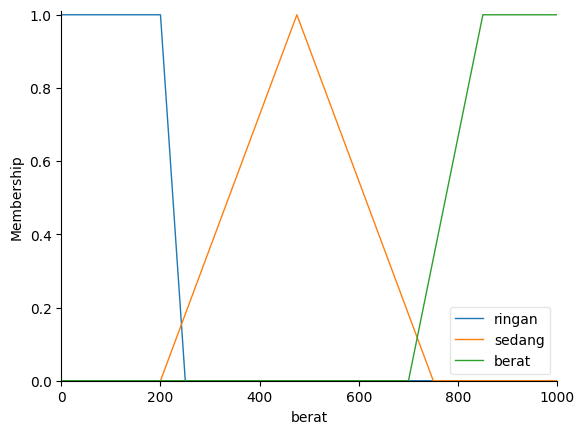

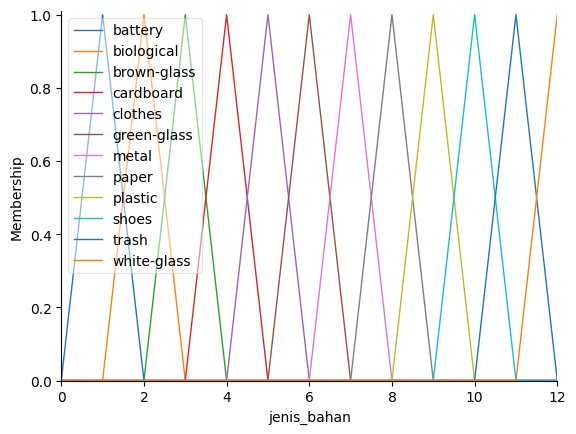

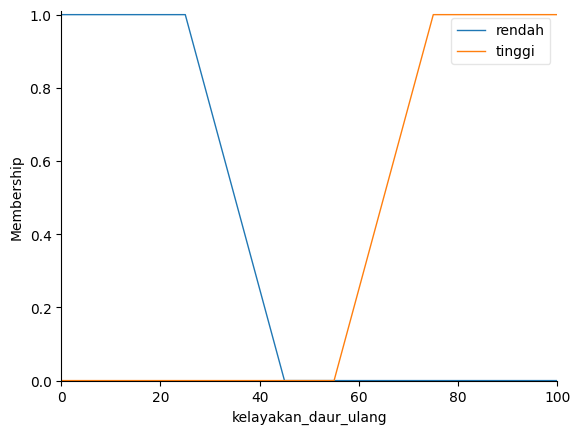

In [ ]:
# Visualisasi beberapa untuk verifikasi
berat.view()
jenis_bahan.view()
kelayakan_daur_ulang.view()

14: Mendefinisikan Basis Aturan Fuzzy

In [ ]:
# --- Mendefinisikan Basis Aturan Fuzzy ---

# Aturan 1: Jika terkontaminasi, kelayakan PASTI rendah.
rule_kontaminasi = ctrl.Rule(kontaminasi['ya'], kelayakan_daur_ulang['rendah'])

# Aturan 2: Jika jenisnya adalah sampah non-daur ulang, kelayakan PASTI rendah.
bahan_non_daur_ulang = jenis_bahan['trash'] | jenis_bahan['biological'] | jenis_bahan['battery'] | jenis_bahan['shoes'] | jenis_bahan['clothes']
rule_non_daur_ulang = ctrl.Rule(bahan_non_daur_ulang, kelayakan_daur_ulang['rendah'])

# Aturan 3: Jika tidak terkontaminasi DAN merupakan bahan daur ulang yang ringan, kelayakan tinggi.
bahan_ringan = jenis_bahan['plastic'] | jenis_bahan['paper'] | jenis_bahan['cardboard']
rule_ringan_bersih = ctrl.Rule(bahan_ringan & berat['ringan'] & kontaminasi['tidak'], kelayakan_daur_ulang['tinggi'])

# Aturan 4: Jika tidak terkontaminasi DAN merupakan bahan daur ulang yang sedang, kelayakan tinggi.
bahan_sedang = jenis_bahan['metal']
rule_sedang_bersih = ctrl.Rule(bahan_sedang & berat['sedang'] & kontaminasi['tidak'], kelayakan_daur_ulang['tinggi'])

# Aturan 5: Jika tidak terkontaminasi DAN merupakan bahan daur ulang yang berat, kelayakan tinggi.
bahan_berat = jenis_bahan['brown-glass'] | jenis_bahan['green-glass'] | jenis_bahan['white-glass']
rule_berat_bersih = ctrl.Rule(bahan_berat & berat['berat'] & kontaminasi['tidak'], kelayakan_daur_ulang['tinggi'])

print("Basis aturan fuzzy yang lengkap berhasil didefinisikan.")

Basis aturan fuzzy yang lengkap berhasil didefinisikan.


15: Membuat Sistem Kontrol

In [ ]:
# --- Membuat Sistem Kontrol ---

# Menggabungkan SEMUA aturan di atas ke dalam satu sistem kontrol
sistem_ctrl = ctrl.ControlSystem([
    rule_kontaminasi,
    rule_non_daur_ulang,
    rule_ringan_bersih,
    rule_sedang_bersih,
    rule_berat_bersih
])

# Membuat instance simulasi dari sistem kontrol yang sudah dibuat
sistem_simulasi = ctrl.ControlSystemSimulation(sistem_ctrl)

print("Sistem Kontrol dan simulasi siap digunakan. Siap untuk pengujian!")

Sistem Kontrol dan simulasi siap digunakan. Siap untuk pengujian!


# BAGIAN 5: PENGUJIAN DAN SIMULASI

16: Pengujian Kasus 1: Kardus Bersih

Skor Kelayakan Daur Ulang (Kardus Bersih): 82.02


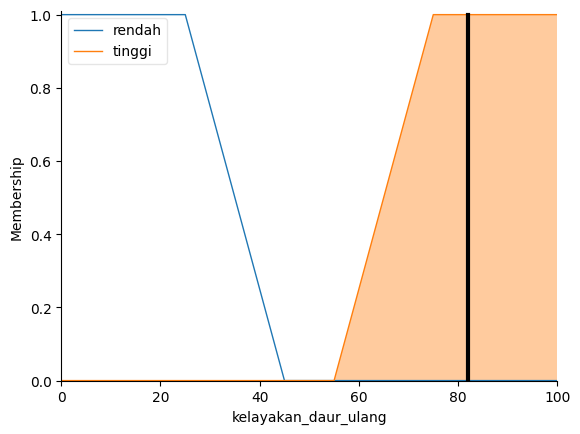

In [ ]:
# Kasus 1: Kardus bersih dengan berat ringan
sistem_simulasi.input['jenis_bahan'] = bahan_map['cardboard']
sistem_simulasi.input['berat'] = 150
sistem_simulasi.input['kontaminasi'] = 0

# Menjalankan komputasi
sistem_simulasi.compute()

# Menampilkan hasil
print(f"Skor Kelayakan Daur Ulang (Kardus Bersih): {sistem_simulasi.output['kelayakan_daur_ulang']:.2f}")
kelayakan_daur_ulang.view(sim=sistem_simulasi)

17: Pengujian Kasus 2: Baterai

Skor Kelayakan Daur Ulang (Baterai): 17.98


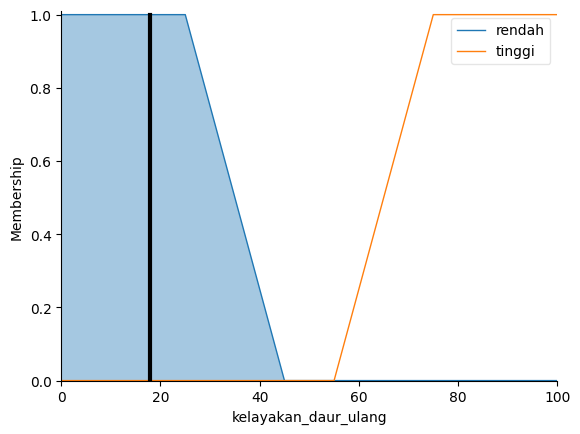

In [ ]:
# Kasus 2: Sebuah baterai
sistem_simulasi.input['jenis_bahan'] = bahan_map['battery']
sistem_simulasi.input['berat'] = 250
sistem_simulasi.input['kontaminasi'] = 0

# Menjalankan komputasi
sistem_simulasi.compute()

# Menampilkan hasil
print(f"Skor Kelayakan Daur Ulang (Baterai): {sistem_simulasi.output['kelayakan_daur_ulang']:.2f}")
kelayakan_daur_ulang.view(sim=sistem_simulasi)

# BAGIAN 6: VISUALISASI LANJUTAN

18: Membuat Plot Permukaan Kontrol 3D

Mempersiapkan data untuk plot 3D...
Menjalankan simulasi fuzzy untuk setiap titik data... (mungkin perlu beberapa saat)
Simulasi selesai.


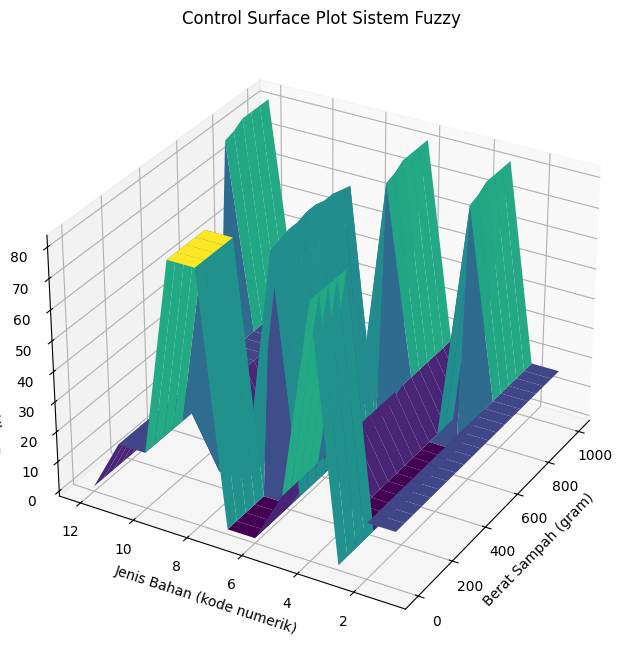

In [ ]:
# Mengimport library yang dibutuhkan untuk plot 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("Mempersiapkan data untuk plot 3D...")

# 1. Menyiapkan rentang nilai untuk input
x_berat = np.arange(0, 1001, 50)
y_jenis = np.arange(1, 13, 1) # Dimulai dari 1, sesuai definisi MF
X, Y = np.meshgrid(x_berat, y_jenis)
Z = np.zeros_like(X)

# 2. Melakukan simulasi untuk setiap titik di grid
print("Menjalankan simulasi fuzzy untuk setiap titik data... (mungkin perlu beberapa saat)")
for i in range(len(y_jenis)):
    for j in range(len(x_berat)):
        sistem_simulasi.input['berat'] = X[i, j]
        sistem_simulasi.input['jenis_bahan'] = Y[i, j]
        sistem_simulasi.input['kontaminasi'] = 0 # Asumsi tidak terkontaminasi untuk plot ini
        sistem_simulasi.compute()
        # Mengatasi kemungkinan KeyError jika tidak ada aturan yang aktif
        if 'kelayakan_daur_ulang' in sistem_simulasi.output:
            Z[i, j] = sistem_simulasi.output['kelayakan_daur_ulang']
        else:
            Z[i, j] = 0 # Beri nilai default jika tidak ada hasil
print("Simulasi selesai.")

# 3. Membuat plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)
ax.set_xlabel('Berat Sampah (gram)')
ax.set_ylabel('Jenis Bahan (kode numerik)')
ax.set_zlabel('Kelayakan Daur Ulang')
ax.set_title('Control Surface Plot Sistem Fuzzy')
ax.view_init(30, 210)
plt.show()